# PINN aplicado à Buckley–Leverett

Leonardo Correia

Nicholas Smaal


In [6]:
import numpy as np
import torch

/Users/leonardocorreia/opt/anaconda3/envs/manim_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

NameError: name 'Net' is not defined

# Desenvolvimento da PDE

$$ velocidade = u(x,t) $$

In [65]:
def f(x,t, net):
    u = net(x,t) #Criando uma variável dependente da posição e do tempo

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx= torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    e= 2.5*10**(-3)
    
    M = 1.0
    fw = (u**2)/((u**2)+((1-u)**2)/M)
    fw_u = torch.autograd.grad(fw.sum(), u, create_graph=True)[0]
    pde = u_t + fw_u*u_x-e*u_xx
    return pde

In [67]:
# Desenvolvimento das condições de contorno

x_bc1 = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc1 = np.zeros((500,1))
u_bc1 = np.zeros((500,1))

x_bc2 = np.zeros((500,1))
t_bc2 = np.random.uniform(low=0.001, high=1.0, size=(500,1))
u_bc2 = np.ones((500,1))

# Treinamento da Rede

In [68]:
itera = 20000
previous_validation_loss = 99999999.0

for epoch in range(itera):
    optimizer.zero_grad() #Zerar o Gradiente 
    
    # Cálculo de Perdas feitas na cond de contorno
    pt_x_bc1 = Variable(torch.from_numpy(x_bc1).float(), requires_grad=False).to(device)
    pt_t_bc1 = Variable(torch.from_numpy(t_bc1).float(), requires_grad=False).to(device)
    pt_u_bc1 = Variable(torch.from_numpy(u_bc1).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc1, pt_t_bc1) # saída de u(x,t)
    mse_u1 = mse_cost_function(net_bc_out, pt_u_bc1)
    
    pt_x_bc2 = Variable(torch.from_numpy(x_bc2).float(), requires_grad=False).to(device)
    pt_t_bc2 = Variable(torch.from_numpy(t_bc2).float(), requires_grad=False).to(device)
    pt_u_bc2 = Variable(torch.from_numpy(u_bc2).float(), requires_grad=False).to(device)
    
    net_bc_out2 = net(pt_x_bc2, pt_t_bc2) # Saída de u(x,t)
    mse_u2 = mse_cost_function(net_bc_out2, pt_u_bc2)
    
    # Cálculo de Perdas feitas na pde
    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(10000,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(10000,1))
    all_zeros = np.zeros((10000,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # saída da função f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combinando as perdas em loss
    loss = mse_u1+ mse_u2 + 2*mse_f
    
    
    loss.backward() # Computando o gradiente com o algorítimo de backward
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)

0 Traning Loss: tensor(0.5064)
1 Traning Loss: tensor(0.5054)
2 Traning Loss: tensor(0.5045)
3 Traning Loss: tensor(0.5037)
4 Traning Loss: tensor(0.5030)
5 Traning Loss: tensor(0.5023)
6 Traning Loss: tensor(0.5017)
7 Traning Loss: tensor(0.5013)
8 Traning Loss: tensor(0.5009)
9 Traning Loss: tensor(0.5006)
10 Traning Loss: tensor(0.5003)
11 Traning Loss: tensor(0.5002)
12 Traning Loss: tensor(0.5001)
13 Traning Loss: tensor(0.5000)
14 Traning Loss: tensor(0.5000)
15 Traning Loss: tensor(0.5000)
16 Traning Loss: tensor(0.5000)
17 Traning Loss: tensor(0.5001)
18 Traning Loss: tensor(0.5001)
19 Traning Loss: tensor(0.5002)
20 Traning Loss: tensor(0.5002)
21 Traning Loss: tensor(0.5003)
22 Traning Loss: tensor(0.5003)
23 Traning Loss: tensor(0.5003)
24 Traning Loss: tensor(0.5003)
25 Traning Loss: tensor(0.5003)
26 Traning Loss: tensor(0.5003)
27 Traning Loss: tensor(0.5002)
28 Traning Loss: tensor(0.5002)
29 Traning Loss: tensor(0.5001)
30 Traning Loss: tensor(0.5001)
31 Traning Loss: t

In [62]:
x=np.arange(0,1,0.05).reshape(-1,1)
t=np.ones(x.shape)*0.1
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
plt.plot(x,u,color='red',linestyle='dashed')

plt.show()     
    

<IPython.core.display.Javascript object>

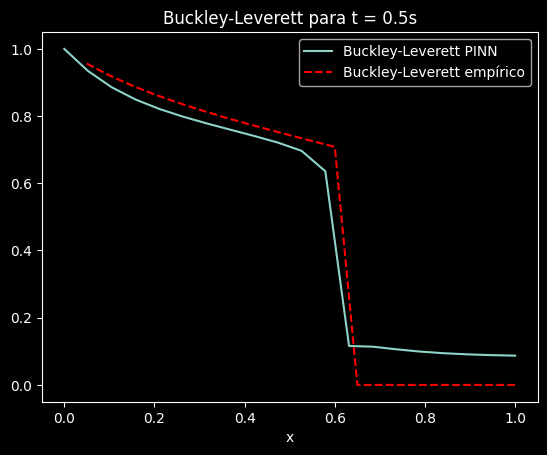

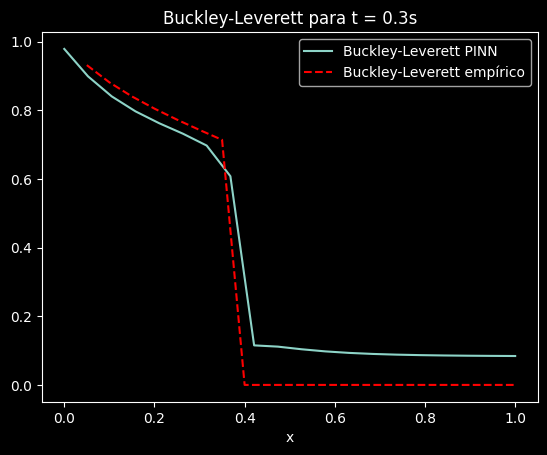

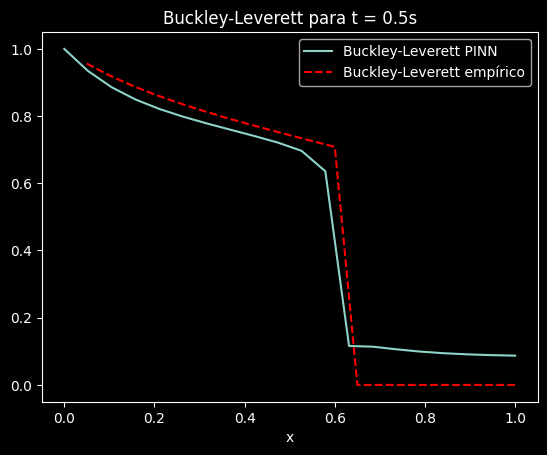